<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Manipulate-Hamiltonian-into-blocks" data-toc-modified-id="Manipulate-Hamiltonian-into-blocks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Manipulate Hamiltonian into blocks</a></span></li><li><span><a href="#Feature-computation" data-toc-modified-id="Feature-computation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature computation</a></span></li><li><span><a href="#Feature-Preprocessing" data-toc-modified-id="Feature-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Preprocessing</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DataLoader</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Tests</a></span><ul class="toc-item"><li><span><a href="#set-up-wigner-d-rotations-matrices" data-toc-modified-id="set-up-wigner-d-rotations-matrices-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>set up wigner-d rotations matrices</a></span></li><li><span><a href="#block-wise-rotations" data-toc-modified-id="block-wise-rotations-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>block wise rotations</a></span></li><li><span><a href="#Rotate-matrix" data-toc-modified-id="Rotate-matrix-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Rotate matrix</a></span></li><li><span><a href="#Eigenvalue-tests" data-toc-modified-id="Eigenvalue-tests-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Eigenvalue tests</a></span></li><li><span><a href="#check-decoupling-of-blocks" data-toc-modified-id="check-decoupling-of-blocks-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>check decoupling of blocks</a></span></li><li><span><a href="#check-feature-rotations" data-toc-modified-id="check-feature-rotations-9.6"><span class="toc-item-num">9.6&nbsp;&nbsp;</span>check feature rotations</a></span></li></ul></li><li><span><a href="#need-to-modify-samples-for-features-to-start-from-1" data-toc-modified-id="need-to-modify-samples-for-features-to-start-from-1-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>need to modify samples for features to start from 1</a></span></li></ul></div>

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import numpy as np
import torch
import json
import ase.io
from itertools import product
import matplotlib.pyplot as plt
# from rascal.representations import SphericalExpansion
import copy
from tqdm import tqdm
from ase.units import Hartree

from torch_hamiltonian_utils.torch_cg import ClebschGordanReal
from torch_hamiltonian_utils.torch_ham import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
from torch_hamiltonian_utils.torch_builder import TensorBuilder

import equistore
from equistore import Labels, TensorBlock, TensorMap
from equistore_utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from equistore_utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine
from equistore_utils.model_hamiltonian import get_feat_keys, get_feat_keys_from_uncoupled 

import importlib
torch.set_default_dtype(torch.float64)

In [2]:
def get_feat_keys_from_uncoupled(block_keys, sigma=None, order_nu=None):
    """Map UNCOUPLED block keys to corresponding feature key. take as extra input the sigma, nu value if required.
    sigma=0 returns all possible sigma values at given 'nu'"""
    blocktype, species1, n1, l1, species2, n2, l2 = block_keys
    feat_blocktype = blocktype
    keys_L=[]
    for L in range(abs(l1-l2), l1+l2+1):
        if sigma is None:
            z = (l1+l2+L)%2
            inv_sigma = 1 - 2*z
        elif abs(sigma)==1:
            inv_sigma = sigma
        else: 
            raise("Please check sigma value, it should be +1 or -1")
        
        if blocktype == 1 and n1 == n2 and l1 == l2:
            feat_blocktype = inv_sigma
                 
        if inv_sigma == -1 and blocktype == 0 and n1 == n2 and l1 == l2:
            continue     
        
        keys_L.append([(order_nu, inv_sigma, L, species1, species2, feat_blocktype)])
    #     feat= (blocktype, L,sigma,species1, species2)
    feat = Labels(["order_nu", "inversion_sigma", "spherical_harmonics_l", "species_center", "species_neighbor", "block_type"], np.asarray(keys_L, dtype=np.int32).reshape(-1,6))
    return feat

In [3]:
# frames = ase.io.read("data/water_rotated/water_rotated_3.xyz",":")
# for f in frames:
#     f.cell = [100,100,100]
#     f.positions += 50
    
# jorbs = json.loads(json.load(open('data/water-hamiltonian/water_orbs.json', "r")))
# orbs = {}
# zdic = {"O" : 8, "H":1}
# for k in jorbs:
#     orbs[zdic[k]] = jorbs[k]
# focks = np.load("data/water_rotated/water_rotated_saph_3.npy", allow_pickle=True)[:len(frames)]
# rotations = np.load("data/water_rotated/rotations_3.npy", allow_pickle = True)
# focks2 = np.load("data/ethanol-hamiltonian/ethanol_saph_orthogonal.npy", allow_pickle = True)[:len(frames)]

In [4]:
def lowdin_orthogonalize(fock, s):
    """
    lowdin orthogonalization of a fock matrix computing the square root of the overlap matrix
    """
    eva, eve = np.linalg.eigh(s)
    sm12 = eve @ np.diag(1.0/np.sqrt(eva)) @ eve.T
    return sm12 @ fock @ sm12

In [5]:
frames = ase.io.read("data/water-hamiltonian/water_coords_1000.xyz",":50")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50
jorbs = json.loads(json.load(open('data/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1, "C":6}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

focks = np.load("data/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
focks = focks.astype(np.float64)

In [6]:
# #generating jagged matrix
# f=[]
# for x in focks:
#     f.append(x)
# for x in focks2:
#     f.append(x)
    
# jagged = np.asanyarray(f)

In [6]:
cg = ClebschGordanReal(8)

## Manipulate Hamiltonian into blocks

In [7]:
blocks = dense_to_blocks(focks, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [8]:
rascal_hypers = {
    "interaction_cutoff": 4.0,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_constant" : 0.2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

lmax = rascal_hypers["max_angular"]

In [9]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [10]:
rho1i = acdc_standardize_keys(rhoi)
rho1i = rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [11]:
rho2i = cg_increment(rho1i, rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [12]:
#rho3i = cg_increment(rho2i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [13]:
rho1ij = cg_increment(rho1i, gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [14]:
#rho2ij = cg_increment(rho2i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [15]:
features = hamiltonian_features(rho2i, rho1ij)

In [16]:
features

TensorMap with 45 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor' 'block_type']
           2             1                    0                   1                1              0
           2             1                    1                   1                1              0
           2             1                    2                   1                1              0
        ...
           2            -1                    4                   1                1              1
           2            -1                    4                   1                1             -1
           2            -1                    4                   1                8              2

In [17]:
from equistore.io import save
save("feature.npz", features)

## Feature Preprocessing

In [18]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    normalized_blocks=[]
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm = block_norm**2 * len(block.samples) 
    
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    raise Exception ("Dont do it!")
    return norm_feat

In [19]:
#norm_feat = normalize_feats(features)

In [21]:
# from equistore.io import save
# save("./norm_feat.npz", norm_feat)

## Dataset

In [20]:
from equistore.io import _labels_from_npz
import equistore.operations as operations

class HamiltonianDataset(torch.utils.data.Dataset):
    #Dataset class
    def __init__(self, feature_path, target, fock, frames, feature_nu = 2):
        #
        self.features = np.load(feature_path, mmap_mode = 'r')
        #self.target = np.load(target_path, mmap_mode = 'r') 
        self.target = target #Uncoupled hamiltonian 
        #self.target = np.load(fock_path, mmap_mode = 'r')
        self.fock = torch.tensor(fock) #fock matrix
        self.keys_features = equistore.io._labels_from_npz(self.features["keys"])
        self.currentkey = self.target.keys[0]
        self.feature_nu = feature_nu
        self.frames = frames
        
        self.allfeatkey = []
        for t_key in self.target.keys:
            feature_key = self.get_feature_keys(t_key)
            self.allfeatkey.append(feature_key)
        #Remove Duplicates
        nodupes = set()
        for x in self.allfeatkey:
            if len(x) > 1:
                for z in x:
                    nodupes.add(tuple(z))
            else:
                nodupes.add(tuple(x[0]))
        
        nodupes = np.array(list(nodupes), np.int32)
        
        self.allfeatkey = Labels(names = self.allfeatkey[0].dtype.names, values = nodupes)
        

    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, structure_idx):
        feature_block, feature_key = self.generate_feature_block(self.features, structure_idx)        
        #samples_filter, target_block_samples = self.get_index_from_idx(self.target.block(self.currentkey).samples, structure_idx)

        if self.currentkey is None:
            target_block = self.fock[sorted(structure_idx)]
        else:
            target_block = operations.slice_block(self.target.block(self.currentkey), 
                                                  samples = Labels(names = ['structure'], 
                                                    values = (np.array(structure_idx)+1).reshape(-1,1)) )
        structure = [self.frames[i] for i in sorted(structure_idx)]
        #Modify feature_block to tensormap
        feature_map = TensorMap(feature_key, feature_block)
        return feature_map, target_block, structure


    def get_feature_keys(self,uncoupled_key):
        return get_feat_keys_from_uncoupled(uncoupled_key, order_nu = self.feature_nu)
    
    def generate_feature_block(self, memmap, structure_idx):
        #Generate the block from npz file
        output = []
        if self.currentkey is None:
            feature_key = self.allfeatkey
                
        else:
            feature_key = self.get_feature_keys(self.currentkey)
            
        for key in feature_key:
            block_index = list(self.keys_features).index(key)
            prefix = f"blocks/{block_index}/values"        
            block_samples = equistore.io._labels_from_npz(memmap[f"{prefix}/samples"])
            block_components = []
            for i in range(1):
                block_components.append(equistore.io._labels_from_npz(memmap[f"{prefix}/components/{i}"]))
            block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
             

            samples_filter, block_samples = self.get_index_from_idx(block_samples, structure_idx)
            

            block_data = memmap[f"{prefix}/data"][samples_filter]
            block = TensorBlock(block_data, block_samples, block_components, block_properties)
            output.append(block)
        return output, feature_key
    
    def get_n_properties(self, memmap, key):
        block_index = list(self.keys_features).index(key)
        prefix = f"blocks/{block_index}/values"  
        block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
        
        return len(block_properties)
    
    def get_index_from_idx(self, block_samples, structure_idx):
        #Get samples label from IDX
        samples = Labels(names = ['structure'], values = np.array(structure_idx).reshape(-1,1))
        
        all_samples = block_samples[['structure']].tolist()
        set_samples_to_slice = set(samples.tolist())
        samples_filter = np.array(
            [sample in set_samples_to_slice for sample in all_samples]
        )
        new_samples = block_samples[samples_filter]

        return samples_filter, new_samples
    
    def collate_output_values(blocks):
        feature_out = []
        target_out = []
        for sample_output in blocks:
            feature_block, target_block, structure = sample_output
            for z in feature_block:
                feature_out.append(torch.tensor(z.values))
            target_out.append(torch.tensor(target_block.values))

        return feature_out, target_out

In [21]:
#test_target_path = "./test_fock.npz"
test_feature_path = "./feature.npz"
test = HamiltonianDataset(test_feature_path, blocks, focks, frames)

## DataLoader

In [22]:
def collate_blocks(block_tuple):
    feature_tensor_map, target_block, structure_array = block_tuple[0]
    
    return feature_tensor_map, target_block, structure_array

In [23]:
from torch.utils.data import DataLoader, BatchSampler, SubsetRandomSampler


#Sampler = torch.utils.data.SubsetRandomSampler(range(1,len(test)+1), generator=None)
Sampler = torch.utils.data.sampler.RandomSampler(test)
#Sampler = torch.utils.data.sampler.SequentialSampler(test)
BSampler = torch.utils.data.sampler.BatchSampler(Sampler, batch_size = 50, drop_last = False)

dataloader = DataLoader(test, sampler = BSampler, collate_fn = collate_blocks)

## Model 

In [24]:
from scipy.stats import rankdata

def get_block_samples(t_key, feature_map):
    f_key = get_feat_keys_from_uncoupled(t_key, None , 2)
    ss = feature_map.block(f_key[0]).samples.copy()
    #ss["structure"] = rankdata(np.abs(ss["structure"]), method='dense')
    return ss

In [25]:
class HamModel(torch.nn.Module):
    #Handles prediction of entire hamiltonian and derived results
    def __init__(self, Hamiltonian_Dataset, device, regularization=None, seed=None, layer_size=None):
        super().__init__()
#         self.features = features 
#         self.target = target
        self.models = torch.nn.ModuleDict()
        self.loss_history={}
        self.device = device
        self.target_keys = Hamiltonian_Dataset.target.keys
        self.block_samples = {}
        self.block_components = {}
        for key in Hamiltonian_Dataset.target.keys:
#             _block_type, _a_i, _n_i, _l_i, _a_j, _n_j, _l_j = key
#             target_keys = Hamiltonian_Dataset.target.keys[Hamiltonian_Dataset.target.blocks_matching(
#                 block_type = _block_type, a_i = _a_i, n_i = _n_i, l_i = _l_i, a_j = _a_j,
#                 n_j = _n_j, l_j = _l_j)]
            
            #self.block_samples[str(key)] = Hamiltonian_Dataset.target.block(key).samples
            self.block_components[str(key)] = Hamiltonian_Dataset.target.block(key).components
        
    
            n_inputs = []
            model_keys = []

            feature_keys = Hamiltonian_Dataset.get_feature_keys(key)
            for f_key in feature_keys: 
                n_features = Hamiltonian_Dataset.get_n_properties(Hamiltonian_Dataset.features, f_key)
                n_inputs.append(n_features)
                model_keys.append(f_key)
                
                
            n_outputs = np.ones_like(n_inputs)
                
            self.models[str(key)] = BlockModel(cg.decouple,n_inputs, n_outputs, device, model_keys, key, seed = seed, hiddenSize = layer_size)
        self.to(device)
            
    def forward(self, x):
        #Ham model uses target keys
        pred_blocks = []
        for t_key in self.target_keys:
            
            pred = self.models[str(t_key)].forward(x) #feature_tensormap must correspond to the correct features, model returns block
            
            #try:
#             print (pred.shape)
#             print ((2 * t_key['l_i'])+1)
#             print ((2 * t_key['l_j']) + 1)
            pred_block = TensorBlock(
                    values=pred.reshape((-1, (2 * t_key['l_i'])+1, (2 * t_key['l_j']) + 1, 1)), #?
                    samples = get_block_samples(t_key, x),
#                     samples = x.block(t_key).samples,
                    components = self.block_components[str(t_key)] ,
                    properties= Labels(["dummy"], np.asarray([[0]], dtype=np.int32))
                )
#             except:
#                 print (t_key)
#                 print (pred)
#                 print (self.block_samples[str(t_key)])
#                 print (self.block_components[str(t_key)])
                
            pred_blocks.append(pred_block)
        pred_hamiltonian = TensorMap(self.target_keys, pred_blocks)
        return(pred_hamiltonian)
    
    #write/fix forward function for train_indiv
    
    def train_individual(self, train_dataloader, regularization_dict, optimizer_type, n_epochs, loss_function, lr):
        #Iterates through the keys of self.model, then for each key we will fit self.model[key] with data[key]
        total = len(self.models)
        for index, t_key in enumerate(self.target_keys):
            print ("Now training on Block {} of {}".format(index, total))
            train_dataloader.dataset.currentkey = t_key
            
            loss_history_key = self.models[str(t_key)].fit(train_dataloader, loss_function, optimizer_type, lr, regularization_dict[str(t_key)], n_epochs)

            self.loss_history[str(t_key)] = loss_history_key
    
    def train_collective(self, train_dataloader, regularization_dict, optimizer_type, n_epochs, loss_function, lr):
        #for every loop through target keys, we predict the corresponding block and assemble the final hamiltonian
        optimizer_dict = {}
        if optimizer_type == "Adam":
            for key in train_dataloader.dataset.target.keys:
                optimizer_dict[str(key)] = torch.optim.Adam(self.models[str(key)].parameters(), lr = lr, weight_decay = regularization_dict[str(key)])
            threshold = 200
            scheduler_threshold = 200
            tol = 0
            history_step = 1000
        
        elif optimizer_type == "LBFGS":
#             for key in train_dataloader.dataset.target.keys:
#                 optimizer_dict[str(key)] = torch.optim.LBFGS(self.models[str(key)].parameters(), lr = lr)
            optimizer_dict[0] = torch.optim.LBFGS(self.models.parameters(), lr = lr)
            threshold = 30
            scheduler_threshold = 30
            tol = 0
            history_step = 10                
        scheduler_dict = {}
        scheduler_dict[0] = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_dict[0], factor = 0.1, patience = scheduler_threshold)
#         for key in train_dataloader.dataset.target.keys:
#             scheduler_dict[str(key)] = torch.optim.lr_scheduler.StepLR(optimizer_dict[str(key)], scheduler_threshold, gamma = 0.5)

        reg_weights = torch.tensor(list(regularization_dict.values()))
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history = []
        pbar = tqdm(range(n_epochs))
        
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
            train_dataloader.dataset.currentkey = None
            
            for x_data, y_data, structure in train_dataloader: 
                self.collective_zg(optimizer_dict)
                #x_data, y_data = x_data.to(self.device), y_data.to(self.device)
                if optimizer_type == "LBFGS":
                    def closure():
                        self.collective_zg(optimizer_dict)
                        _pred = self.forward(x_data)
                        _pred_loss = loss_function(_pred, y_data, structure, orbs)       
                        _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                          
                        _reg_loss = self.get_regression_values(reg_weights) #Only works for 1 layer #Need to change!!
                        _new_loss = _pred_loss + _reg_loss
                        _new_loss.backward()
                        return _new_loss
                    for value in optimizer_dict.values():
                        value.step(closure)
#                     for param in self.parameters():
#                         print (param.grad)
                elif optimizer_type == "Adam":
                    pred = self.forward(x_data)
                    pred_loss = loss_function(pred, y_data, structure, orbs)  
#                     reg_loss = torch.sum(torch.pow(self.nn.weight,2))#Only works for 1 layer
                    new_loss = pred_loss 
                    new_loss.backward()
                    self.collective_step(optimizer_dict)
            with torch.no_grad():
                current_loss = 0 
                for x_data, y_data, structure in train_dataloader:
                    pred = self.forward(x_data)
                    current_loss  += loss_function(pred, y_data, structure, orbs)   #Loss should be normalized already
                pred_loss = current_loss
                reg_loss = self.get_regression_values(reg_weights)#Only works for 1 layer
                new_loss = pred_loss + reg_loss
                for scheduler in scheduler_dict.values():
                    scheduler.step(new_loss)
                if pred_loss >100000 or (pred_loss.isnan().any()) :
                    print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                    self.load_state_dict(best_state)
                    if optimizer_type == "Adam":
                        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg.item())
                    elif optimizer_type == "LBFGS":
                        optimizer = torch.optim.LBFGS(self.parameters(), lr = lr)

                if epoch % history_step == 1:
                    loss_history.append(lowest_loss.item())
                
                if lowest_loss - new_loss > tol: #threshold to stop training             
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss 
                    trigger = 0 
                    
                    
                else:
                    trigger += 1
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history
        
    def collective_step(self, dictionary):
        for value in dictionary.values():
            value.step()
            
    def collective_zg(self, dictionary):
        for value in dictionary.values():
            value.zero_grad()
    
    def get_regression_values(self, reg_weights):
        output = []
        for param in self.parameters():
            output.append(torch.sum(torch.pow(param,2)))
        try:
            output = torch.sum(torch.tensor(output) * reg_weights)
        except:
            output = 0
        return output


In [26]:
class BlockModel(torch.nn.Module): #Currently only 1 model per block
    def __init__(self, reconstruction_function, inputSize, outputSize, device, keys, target_key, seed = None, hiddenSize = None):
        super().__init__()
        self.reconstruction_function = reconstruction_function
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.device = device
        self.keys = keys
        self.target_key = target_key
        self.hiddenSize = hiddenSize
        self.initialize_model(seed)
        
        self.to(device)
    
    def initialize_model(self, seed):
        
        if seed is not None:
            torch.manual_seed(seed)
        
        self.models = torch.nn.ModuleDict()
        for index, key in enumerate(self.keys):
             if key['spherical_harmonics_l'] == 0:
                self.models[str(key)] = InvariantNonLinearModel(self.inputSize[index], self.hiddenSize, self.outputSize[index])
#                 self.models[str(key)] = torch.nn.Linear(self.inputSize[index], self.outputSize[index], bias = True)
             else:
                self.models[str(key)] = torch.nn.Linear(self.inputSize[index], self.outputSize[index], bias = False)
        
    def forward(self, feature_tensormap):
        #Block model uses feature keys
        pred_values = {}
        for key in self.keys:
            feature_values = feature_tensormap.block(key).values
            d1, d2, d3 = feature_values.shape
            L = int((d2 -1)/2)
            pred = self.models[str(key)](torch.tensor(feature_values.reshape(d1 * d2, d3)))
            pred = pred.reshape(d1,d2)
            pred_values[L] = pred
        
        pred_block_values = self.reconstruction_function({(self.target_key['l_i'],self.target_key['l_j']) : pred_values})
        
        #DOES NOT WORK FOR BATCHES

        #pred = torch.hstack(pred_values)
        #pred = self.reconstruction_function(pred_values)
        return pred_block_values 

    
    def fit(self,traindata_loader, loss_function, optimizer_type, lr, reg, n_epochs):
        if optimizer_type == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg.item())
            threshold = 200
            scheduler_threshold = 50
            tol = 0
            history_step = 1000
        
        elif optimizer_type == "LBFGS":
            optimizer = torch.optim.LBFGS(self.parameters(), lr = lr)
            threshold = 30
            scheduler_threshold = 10
            tol = 0
            history_step = 10
            
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = scheduler_threshold)      
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history = []
        pbar = tqdm(range(n_epochs))
        
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
            
            for x_data, y_data, structure in traindata_loader: 
                optimizer.zero_grad()
                #x_data, y_data = x_data.to(self.device), y_data.to(self.device)
                if optimizer_type == "LBFGS":
                    def closure():
                        optimizer.zero_grad()
                        _pred = self.forward(x_data)                                        
                        _pred_loss = loss_function(_pred, y_data.values)
                        _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
                        _reg_loss = self.get_regression_values(reg.item()) #Only works for 1 layer
                        _new_loss = _pred_loss + _reg_loss
                        _new_loss.backward()
                        return _new_loss
                    optimizer.step(closure)

                elif optimizer_type == "Adam":
                    pred = self.forward(x_data)
                    pred_loss = loss_function(pred, y_data.values)
                    #reg_loss = self.get_regression_values(reg.item())#Only works for 1 layer
                    new_loss = pred_loss #+ reg_loss
                    new_loss.backward()

                    optimizer.step()
                
            with torch.no_grad():
                current_loss = 0 
                for x_data, y_data, structure in traindata_loader:
                    pred = self.forward(x_data)
                    current_loss  += loss_function(pred, y_data.values) #Loss should be normalized already
                pred_loss = current_loss
                reg_loss = self.get_regression_values(reg.item()) 
                new_loss = pred_loss + reg_loss
                scheduler.step(new_loss)
                if pred_loss >100000 or (pred_loss.isnan().any()) :
                    print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                    self.load_state_dict(best_state)
                    if optimizer_type == "Adam":
                        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg.item())
                    elif optimizer_type == "LBFGS":
                        optimizer = torch.optim.LBFGS(self.parameters(), lr = lr)

                if epoch % history_step == 1:
                    loss_history.append(lowest_loss.item())
                
                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss 
                    trigger = 0 
                    
                    
                else:
                    trigger += 1
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history
    
    def get_regression_values(self, reg_weights):
        output = []
        for param in self.parameters():
            output.append(torch.sum(torch.pow(param,2)))
        try:
            output = torch.sum(torch.tensor(output) * reg_weights)
        except:
            output = 0
        return output

In [27]:
class InvariantNonLinearModel(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
    ):
        """ """
        super().__init__()
        
        
        self.invariant_nn = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size, bias=False),
            torch.nn.ELU(),
#             torch.nn.Linear(hidden_size, hidden_size),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(hidden_size, hidden_size),
#             torch.nn.GroupNorm(8,hidden_size),
#             torch.nn.Softplus(),
#             torch.nn.Linear(hidden_size, hidden_size),
#             torch.nn.GroupNorm(8,hidden_size),
#             torch.nn.Softplus(),
#             torch.nn.GroupNorm(4, hidden_size),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_size, hidden_size),
#             torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, output_size, bias=False)
            )
        
        # Define the output layer that makes the prediction
        #self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input: torch.Tensor):
        result = self.invariant_nn(input)
        
        return result

## Training

In [28]:
def mse_block_values(pred, true):
    true = true.reshape(true.shape[:-1]) 
    MSE = torch.sum(torch.pow(true - pred,2)) / torch.numel(true)
    return torch.mean(MSE)*(Hartree)**2

def mse_full(pred_blocks, fock,frame, orbs):
    predicted = blocks_to_dense(pred_blocks, frame, orbs)
    #fock = torch.tensor(focks)
    #print (mse_full_blockwise(pred_blocks, blocks, frame, orbs))
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = ((torch.linalg.norm(fock[i]-predicted[i]))**2)/torch.numel(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)*(Hartree)**2#, mse_loss

def mse_full_blockwise(pred_blocks, block_tensormap, frame, orbs):
    indiv_mse = torch.zeros(1)
    for key,block in pred_blocks:
        #MSE = ((torch.linalg.norm(block_tensormap.block(key).values-block.values))**2)
        print (key)
        print (((torch.linalg.norm(block_tensormap.block(key).values- block.values))**2)/ torch.numel(block_tensormap.block(key).values))
        print (torch.sum(torch.pow(block_tensormap.block(key).values - block.values, 2)) / torch.numel(block_tensormap.block(key).values))
        MSE = torch.sum(torch.pow(block_tensormap.block(key).values - block.values, 2)) / torch.numel(block_tensormap.block(key).values)
        indiv_mse += MSE
    
    return (indiv_mse/len(frame))*(Hartree)**2, indiv_mse
    
def mse_eigvals(pred_blocks, fock, frame, orbs):
    fock = torch.tensor(focks)
    predicted = blocks_to_dense(pred_blocks, frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)*(Hartree)**2


In [42]:
model = HamModel(test, "cpu", None, 1234, 128)

In [30]:
dataloader.dataset.currentkey = None
for x_data, y_data, structure in dataloader:    
    pred = model(x_data)  

In [43]:
optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=1,  line_search_fn="strong_wolfe",
        history_size=256, tolerance_grad=1e-20, tolerance_change=1e-20
    )

In [44]:
all_losses = []
for epoch in range(1000):
    dataloader.dataset.currentkey = None
    for x_data, y_data, structure in dataloader:    
        def single_step():
            optimizer.zero_grad()
            pred = model(x_data)
            loss = mse_full(pred, y_data, structure, orbs)
            loss.backward()
            return loss

        loss = optimizer.step(single_step)

        all_losses.append(loss.item())

        if epoch % 1 == 0:
            print(epoch, loss.item()) 

0 58.67585650463337
1 13.443867385284962
2 9.66026337100206
3 2.207289800478552
4 0.6386726824355378
5 0.5771023252054059
6 0.5546570063039103
7 0.5403328815604065
8 0.5382171113499423
9 0.5314785468258695
10 0.515656323287001
11 0.4628547625269237
12 0.4032072159371927
13 0.3911112154973252
14 0.38704083441600556
15 0.3858585167760984
16 0.3853846501987214
17 0.3852594766617301
18 0.3834002000823119
19 0.38276962609824117
20 0.37927780336304623
21 0.37485208396134634
22 0.37165727887928324
23 0.369393051222528
24 0.3591685470856261
25 0.35298171476284135
26 0.3456019134182031
27 0.33475077584967206
28 0.3262996874625082
29 0.3256704817964604
30 0.31879998781586455
31 0.30726576700653124
32 0.3023906128821411
33 0.29579935493477666
34 0.2937452805359731
35 0.28766336555970284
36 0.28328320633282916
37 0.271393692236306
38 0.2615850555269568
39 0.21958249171107325
40 0.21748207595249305
41 0.191006707475752
42 0.19071255128145667
43 0.1694221470062465
44 0.1648841072637875
45 0.14721674

341 0.011445780881190462
342 0.011400769964564636
343 0.011367709652484738
344 0.011363203007494632
345 0.011357465863491048
346 0.01135316112227329
347 0.011351870296419611
348 0.011349864196348366
349 0.011348185212805272
350 0.011335684564027216
351 0.01131736840054238
352 0.011296477799345978
353 0.011281244819571434
354 0.0112660839534125
355 0.011257066039514122
356 0.011250355816324827
357 0.011247537357312482
358 0.011245310213346998
359 0.011244038055507215
360 0.011242497261113534
361 0.01123334319955743
362 0.011188601951690382
363 0.01106183265956858
364 0.010922105666562145
365 0.01080129544568439
366 0.010765239967741355
367 0.010743338920964603
368 0.01070704817174191
369 0.010592745771066359
370 0.010463595101376656
371 0.01041059420855859
372 0.010347044461318828
373 0.010317822575070986
374 0.010295275263948384
375 0.01026206951844443
376 0.01020924978187072
377 0.010122172386437001
378 0.010013067988247859
379 0.009990724792555264
380 0.009916702181234738
381 0.00990

671 0.00588268135656672
672 0.005854888264037702
673 0.005819901960784967
674 0.00580352211763758
675 0.005791899642516214
676 0.005784033969388189
677 0.005776753526112263
678 0.005763766425369292
679 0.00575920014341426
680 0.005755148402398861
681 0.005747757727636947
682 0.005738307302845292
683 0.00573168664769892
684 0.005729672859584604
685 0.0057289362962552794
686 0.005727223197326721
687 0.005726354139361823
688 0.0057241211386402525
689 0.005723000465542735
690 0.005722030845056811
691 0.005721603197968286
692 0.005721349677103128
693 0.005721068533361963
694 0.005720556825015966
695 0.005719647661978679
696 0.00571575186151741
697 0.005713061789741055
698 0.00570822270676217
699 0.005705155522419263
700 0.005703028643395191
701 0.0057023228298726586
702 0.005702130108271676
703 0.005701898088080323
704 0.005700090939872897
705 0.005694128751477855
706 0.005689964178235063
707 0.005686859850523146
708 0.005683804965872811
709 0.005678570107000056
710 0.0056668988362057054
71

999 0.0038220127004691628


In [66]:
for epoch in range(1000):
    dataloader.dataset.currentkey = None
    for x_data, y_data, structure in dataloader:    
        def single_step():
            optimizer.zero_grad()
            pred = model(x_data)
            loss = mse_full(pred, y_data, structure, orbs)
            loss.backward()
            return loss

        loss = optimizer.step(single_step)

        all_losses.append(loss.item())

        if epoch % 1 == 0:
            print(epoch, loss.item()) 

0 0.0012464972788176667
1 0.001246497261380447
2 0.001246497243966604
3 0.0012464972265763773
4 0.001246497209210777
5 0.0012464971918664859
6 0.0012464971745468868
7 0.0012464971572494008
8 0.0012464971399747554
9 0.0012464971227227823
10 0.0012464971054942937
11 0.0012464970901062589
12 0.001246497075165657
13 0.001246497060249157
14 0.0012464970453594266
15 0.0012464970304943783
16 0.00124649701565079
17 0.0012464970008271672
18 0.0012464969860254327
19 0.001246496971243852
20 0.0012464969564919628
21 0.0012464969417559527
22 0.0012464969270477506
23 0.0012464969123584773
24 0.0012464968976892345
25 0.0012464968830454978
26 0.0012464968684161948
27 0.0012464968538118174
28 0.0012464968392307562
29 0.001246496824673962
30 0.0012464968101291599
31 0.0012464967956094652
32 0.0012464967811091087
33 0.0012464967666273087
34 0.0012464967521646842
35 0.0012464967377236737
36 0.0012464967233024266
37 0.0012464967088970489


KeyboardInterrupt: 

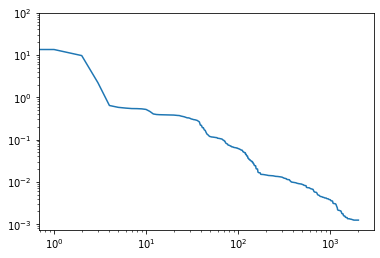

In [67]:
plt.loglog(all_losses)

## Evaluation

In [60]:
#Load test set
test_frames1 = ase.io.read("data/water-hamiltonian/water_coords_1000.xyz","50:80")
# frames2 = ase.io.read("data/ethanol-hamiltonian/ethanol_4500.xyz", ":2")
test_frames = test_frames1 #+ frames2
for f in test_frames:
    f.cell = [100,100,100]
    f.positions += 50

# test_focks1 = np.load("data/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[50:60]
# focks2 = np.load("data/ethanol-hamiltonian/ethanol_saph_orthogonal.npy", allow_pickle = True)[:len(frames2)]

test_focks1 = np.load("data/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[50:80]
test_focks = test_focks1.astype(np.float64)
# test_focks = np.load("data/water-hamiltonian/water_fock.npy", allow_pickle=True)[50:80]
# test_overlap = np.load("data/water-hamiltonian/water_overlap.npy", allow_pickle=True)[50:80]

# test_orthogonal = []
# for i in range(len(test_focks)): 
#     test_focks[i] = fix_pyscf_l1(test_focks[i],test_frames[i], orbs)
#     test_overlap[i] = fix_pyscf_l1(test_overlap[i],test_frames[i], orbs)
#     test_orthogonal.append(lowdin_orthogonalize(test_focks[i], test_overlap[i]))
# test_focks = np.asarray(test_orthogonal, dtype=np.float64)
    
test_blocks = dense_to_blocks(test_focks, test_frames, orbs)
test_fock_bc = couple_blocks(test_blocks, cg)

In [61]:
test_rhoi = spex.compute(test_frames)
test_gij = pairs.compute(test_frames)
test_rho1i = acdc_standardize_keys(test_rhoi)
test_rho1i = test_rho1i.keys_to_properties(['species_neighbor'])
test_gij =  acdc_standardize_keys(test_gij)
test_rho2i = cg_increment(test_rho1i, test_rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)
test_rho1ij = cg_increment(test_rho1i, test_gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

test_features = hamiltonian_features(test_rho2i, test_rho1ij)

In [62]:
#from equistore.io import save
save("test_feature.npz", test_features)

In [63]:
test_feature_path = "./test_feature.npz"
testing = HamiltonianDataset(test_feature_path, test_blocks, test_focks, test_frames)

In [64]:
from torch.utils.data import DataLoader, BatchSampler, SubsetRandomSampler


#Sampler = torch.utils.data.SubsetRandomSampler(range(1,len(test)+1), generator=None)
test_Sampler = torch.utils.data.sampler.RandomSampler(testing)
test_BSampler = torch.utils.data.sampler.BatchSampler(test_Sampler, batch_size = 50, drop_last = False)

test_dataloader = DataLoader(testing, sampler = test_BSampler, collate_fn = collate_blocks)

In [65]:
testing.currentkey = None
test_dataloader.dataset.currentkey = None
for x_data, y_data, structures in test_dataloader:
    t_pred = model(x_data)
    print (mse_full(t_pred, torch.tensor(test_focks), structures, orbs))

tensor(0.0035, grad_fn=<MulBackward0>)


### Test for equivariance of the Model

In [78]:
rot_frames = frames.copy()
for i, f in enumerate(rot_frames):
    f.positions = 50+(50-frames[i].positions[:,[2,0,1]])
    f.positions[:,]

In [82]:
rot_rhoi = spex.compute(rot_frames)
rot_gij = pairs.compute(rot_frames)
rot_rho1i = acdc_standardize_keys(rot_rhoi)
rot_rho1i = rot_rho1i.keys_to_properties(['species_neighbor'])
rot_gij =  acdc_standardize_keys(rot_gij)
rot_rho2i = cg_increment(rot_rho1i, rot_rho1i, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)
rot_rho1ij = cg_increment(rot_rho1i, rot_gij, lcut=lmax, other_keys_match=["species_center"], clebsch_gordan=cg)

In [83]:
rot_features = hamiltonian_features(rot_rho2i, rot_rho1ij)

#from equistore.io import save
save("rot_feature.npz", rot_features)

In [84]:
feature_path = "./rot_feature.npz"
rot_dataset = HamiltonianDataset(feature_path, blocks, focks, frames)

In [89]:
rot_pred = model(rot_features)
rot_pred_fock = blocks_to_dense(rot_pred, rot_frames, orbs)
torch.linalg.eigvalsh(rot_pred_fock[2])

tensor([-1.3112, -0.6972, -0.5651, -0.4966,  0.1740,  0.2535],
       grad_fn=<LinalgEighBackward0>)

In [88]:
pred = model(features)
pred_fock = blocks_to_dense(pred, frames, orbs)
torch.linalg.eigvalsh(pred_fock[2])

tensor([-1.3112, -0.6972, -0.5651, -0.4966,  0.1740,  0.2535],
       grad_fn=<LinalgEighBackward0>)

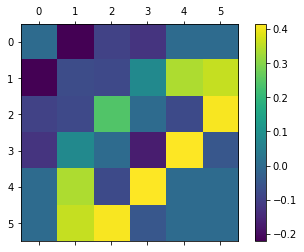

In [59]:
figure = plt.figure()
axes = figure.add_subplot(111)
 
caxes = axes.matshow(rot_pred_fock[0].cpu().detach().numpy()- pred_fock[0].cpu().detach().numpy(), interpolation ='nearest')
figure.colorbar(caxes)
 
plt.show()